In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

In [13]:
def converter(dBm): #helper function to interpret RSSI values
    return 10**((dBm+90)/10)
#---------------------------Data Analysis--------------------------------------
#1. Get all the labels (locations)
#data file name is in structure of "label_attempt.json" (e.g "0,0_1.json"), each file contains a list of dictionaries {"MAC":mac, "RSSI":rssi}
base_path = "data_old"
labels_set = set()
#iterate through all the files in base_path and get all the labels first
for filename in os.listdir(base_path):
    label = filename.split("_")[0]
    labels_set.add(label)
labels = list(labels_set)

labels = [f"{i}_0" for i in range(0,7)]

#2. for each location, get a mac list
mac_set = set()
for label in labels:
    #initial set
    set_a = set()
    with open(os.path.join(base_path, label+"_0.json"),'r') as f:
        data = json.load(f)
        for d in data:
            d = json.loads(d)
            set_a.add(d['MAC'])
    #for all files that start with label
    for filename in os.listdir(base_path):      
        if filename.startswith(label): #if the file starts with the label
            set_b = set()
            with open(os.path.join(base_path, filename), 'r') as f:
                data = json.load(f)
                for d in data:
                    d = json.loads(d)
                    set_b.add(d['MAC'])
            set_a = set_a.intersection(set_b)
    mac_set = mac_set.union(set_a)
mac_list = list(mac_set)
print("Number of mac addresses: ", len(mac_list))

#3. Now read data and put it into a dataframe
data_list = []

# for filename in os.listdir(base_path):
#     #first check the label is valid
#     label = filename.split("_")[0]
#     if label not in labels:
#         continue #not valid
#     #ok now we have valid labels
#     with open(os.path.join(base_path, filename), 'r') as f:
#         vector = np.full(len(mac_list),-100)
#         data = json.load(f)
#         #creating vector...
#         for d in data:
#             d = json.loads(d) #for each mac entry
#             if d['MAC'] in mac_list:
#                 idx = mac_list.index(d['MAC'])
#                 vector[idx] = d['RSSI']
#         #now we have the vector, add it to the datalist
#         #label in form of tuple (x,y)
#         label = tuple(map(int, label.split(",")))
#         data_list.append((label,vector))

for label in labels:
    #first check the label is valid  
    for i in range(101):
        filename = label+"_"+str(i)+".json"
        try:
            with open(os.path.join(base_path, filename), 'r') as f:
                vector = np.full(len(mac_list),-100)
                data = json.load(f)
                for d in data:
                    d = json.loads(d) #for each mac entry
                    if d['MAC'] in mac_list:
                        idx = mac_list.index(d['MAC'])
                        vector[idx] = d['RSSI']
                data_list.append((label[0],vector))
        except:
            continue

#convert to dataframe
df = pd.DataFrame(data_list, columns=['label','vector'])


Number of mac addresses:  69


In [14]:
df

,label,vector
0,0,"[-87, -92, -100, -91, -89, -100, -79, -89, -73..."
1,0,"[-85, -84, -100, -100, -87, -100, -82, -84, -7..."
2,0,"[-84, -85, -100, -94, -90, -100, -79, -86, -72..."
3,0,"[-83, -84, -100, -100, -87, -100, -80, -86, -7..."
4,0,"[-87, -85, -100, -100, -89, -100, -78, -86, -7..."
...,...,...
596,6,"[-93, -94, -89, -100, -92, -100, -90, -100, -8..."
597,6,"[-100, -100, -88, -100, -100, -100, -89, -100,..."
598,6,"[-93, -100, -90, -100, -100, -100, -86, -100, ..."
599,6,"[-93, -100, -90, -100, -95, -100, -87, -100, -..."


In [5]:
#find x and y range
x_range = []
y_range = []

for label in labels:
    xy = label.split(",")
    x_range.append(int(xy[0]))
    y_range.append(int(xy[1]))

x_range = [min(x_range), max(x_range)]
y_range = [min(y_range), max(y_range)]
print("x range: ", x_range)
print("y range: ", y_range)

IndexError: list index out of range

In [24]:
#---------------------------Data Visualization--------------------------------------
#vector is len(mac_set) long, which is a large dimension. So let's use auto encoder to reduce the dimension and visualize the data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#standardize the data
scaler = StandardScaler()
vec = df["vector"].values.tolist()
scaled_data = scaler.fit_transform(vec)

#PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

#plot 3d
x = pca_data[:,0]
y = pca_data[:,1]

#import plotly
import plotly.graph_objects as go
import plotly.express as px


fig = px.scatter(x=x, y=y, color=df["label"])
#adjust figure size
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

In [31]:
#---------------------------Model Training------------...everything--------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor

multi_output_classifier = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001, solver='adam', verbose=0,  random_state=21,tol=0.000000001))
regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=0))

#split data
X = df["vector"].values.tolist()
y = df["label"].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#train model
multi_output_classifier.fit(X_train, y_train)
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)

#convert pred to a tuple
pred = [tuple(x) for x in pred]

#calculate MSE error
error = mean_squared_error(y_test, pred)
print("MSE Error(units): ", error)


MSE Error(units):  0.4331281250000001


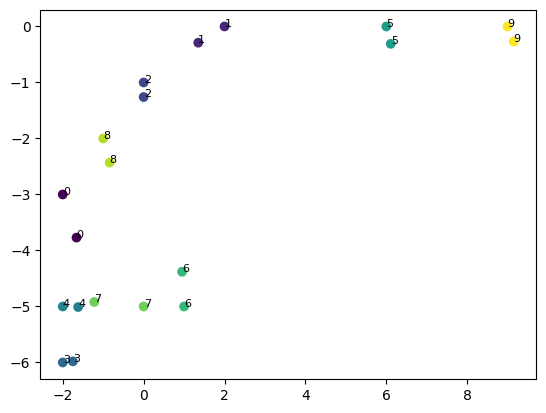

In [32]:
#------------------------------------model validation------------------------------------
#10 samples from X_test, y_test
sample_idx =  np.random.choice(len(X_test), 10, replace=False)
X_sample = [X_test[i] for i in sample_idx]
y_sample = [y_test[i] for i in sample_idx]

#predict
pred = regressor.predict(X_sample)

#plot both ground truth and predict with color coding
x = []
y = []
x2 = []
y2 = []
for i in range(len(pred)):
    x.append(y_sample[i][0])
    y.append(y_sample[i][1])
    x2.append(pred[i][0])
    y2.append(pred[i][1])
#scatter plot, plot each point with different color
colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(x))]
plt.scatter(x, y, c=colors)
colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(x2))]
plt.scatter(x2, y2, c=colors)

for i, txt in enumerate(y_sample):
    plt.text(x[i], y[i], str(i), fontsize=8)

for i, txt in enumerate(pred):
    plt.text(x2[i], y2[i], str(i), fontsize=8)

plt.show()


In [45]:
from client import Client

test_subject = Client("Tester")

#evaluation with separate evaluation data
eval_path = "test_data"
filenames = os.listdir(eval_path)
filenames.sort()
for i in range(16):
    try:
        filename = f"test0_{i}_0.json"
        with open(os.path.join(eval_path, filename), 'r') as f:
            data = json.load(f)
            vector = np.full(len(mac_list),-100)
            #creating vector...
            for d in data:
                d = json.loads(d)
                if d['MAC'] in mac_list:
                    idx = mac_list.index(d['MAC'])
                    vector[idx] = d['RSSI']
                    test_subject.put_vector(vector)
    except:
        print("File not found: ",filename)
        continue

path = []
for i in range(len(test_subject)):
    vec = test_subject.get_vector(i)
    pred = regressor.predict([vec])
    path.append(pred[0])

#use plotly to plot the path
x = []
y = []
for p in path:
    x.append(p[0])
    y.append(p[1])

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers'))
fig.show()


File not found:  test0_10_0.json


In [ ]:
#mlp regressor made using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as pl
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.data = torch.from_numpy(df["vector"].values)
        self.label = torch.from_numpy(np.array(df["label"].values.tolist()))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]


class MLPRegressor(nn.Module):
    #input size is the number of mac addresses, output is 2 (x,y)
    def __init__(self, intput_size):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequentail(
            nn.Linear(input_size,100),
            nn.LeakyReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100,100),
            nn.LeakyReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100,50),
            nn.LeakyReLU(),
            nn.Linear(50,2)
        )

    def forward(self, x):
        return self.model(x)

class MLPRegressorLightning(pl.LightningModule):
    def __init__(self, input_size):
        super(MLPRegressorLightning, self).__init__()
        self.model = MLPRegressor(input_size)
        self.criterion = nn.MSELoss()
        self.lr = 0.001

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

#train model
model = MLPRegressorLightning(len(mac_list))
trainer = pl.Trainer(gpus=1, max_epochs=100)
trainer.fit(model, train_dataloader, val_dataloader)
